In [22]:
import numpy as np
import cv2
import os
from math import ceil
import time
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import pandas as pd
%matplotlib inline

In [23]:
labels = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

#建立相應資料夾
#建立處理過後的 training 資料夾
train_path = "ml100-03-final/processed image data/train/"
for l in labels:
    try:
        os.makedirs(os.path.join(train_path, l))
    except OSError:
        pass
    
#建立處理過後的 training for validation 資料夾
val_path = "ml100-03-final/processed image data/val/"
for l in labels:
    try:
        os.makedirs(os.path.join(val_path, l))
    except OSError:
        pass
    
#建立處理過後的 testing 資料夾
try:
    os.makedirs("ml100-03-final/processed image data/test")
except OSError:
    pass

In [24]:
def preprocessing_from_folder(path_from, path_train, path_val, rt):
    nf = len(os.listdir(path_from))
    for i, filename in enumerate(os.listdir(path_from)):
        im = cv2.imread(os.path.join(path_from, filename))
        h = im.shape[0]
        w = im.shape[1]
        #旋轉使其寬>高
        if(h > w):   
            im = np.rot90(im)
        h = im.shape[0]
        w = im.shape[1]
        #等比例調整使其高度是240
        r = 240/h
        im = cv2.resize(im, (ceil(w*r), 240), interpolation=cv2.INTER_CUBIC)
        h = im.shape[0]
        w = im.shape[1]
        #砍掉左右不需要的部分，只留下240*240 中間的正方形
        x_l = ceil((w-240)/2)
        crop_img = im[0:240, x_l:x_l+240]
        #rt 為要拿來分割training data 的比例
        if ((i/(nf-1))<=rt):
            cv2.imwrite(os.path.join(path_train, filename), crop_img)
        else:
            cv2.imwrite(os.path.join(path_val, filename), crop_img)

In [25]:
from_path = "ml100-03-final/image_data/train/"
rt = 0.95
#圖片格式整理，並且另存整理後的圖片
for l in labels:
    preprocessing_from_folder(os.path.join(from_path, l), os.path.join(train_path, l), os.path.join(val_path, l), rt)

from_test_path = "ml100-03-final/image_data/test/"
target_test_path = "ml100-03-final/processed image data/test/"
preprocessing_from_folder(from_test_path, target_test_path, [], 1)

圖片格式整理前
type= <class 'numpy.ndarray'>  H:326 W:500


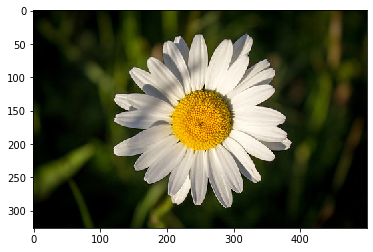

圖片格式整理後
type= <class 'numpy.ndarray'>  H:240 W:240


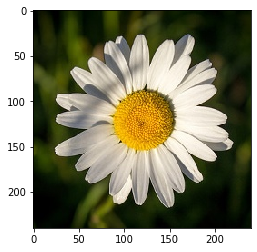

In [26]:
print('圖片格式整理前')
img = cv2.imread('ml100-03-final/image_data/train/daisy/0a3e7507742e246b3a2e630debbbaf99.jpg')
print('type=', type(img), ' H:%d W:%d'%((img.shape)[0], (img.shape)[1]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print('圖片格式整理後')
img = cv2.imread('ml100-03-final/processed image data/train/daisy/0a3e7507742e246b3a2e630debbbaf99.jpg')
print('type=', type(img), ' H:%d W:%d'%((img.shape)[0], (img.shape)[1]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
#建立 (x_train, y_train) 與 (x_test, y_test)

sr = 0.95 #分割要拿來train的比例

num_label = []
x_train = []
x_test = []
y_train = []
y_test = []
for i, f_path in enumerate(folders_target_list[:5]):
    ni = len(os.listdir(f_path))
    for j, filename in enumerate(os.listdir(f_path)):
        im = cv2.imread(os.path.join(f_path, filename))
        
        #label
        y_tmp = np.zeros((5,), dtype=int)
        y_tmp[i] = 1
        #將每一個label 中 sr比率的 (x, y) pair 拿來training 使用
        if(j < ceil(ni*sr)):
            x_train.append(im)
            y_train.append(y_tmp)
        else:
            x_test.append(im)
            y_test.append(y_tmp)
    num_label.append(ni)

NameError: name 'folders_target_list' is not defined

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

#normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [ ]:
print('type(x_train)=', type(x_train), ', dtype = ', x_train.dtype)
print('x_train shape = ', x_train.shape)

print('type(y_train)=', type(y_train), ', dtype = ', y_train.dtype)
print('y_train shape = ', y_train.shape)

print('type(x_test)=', type(x_test), ', dtype = ', x_test.dtype)
print('x_test shape = ', x_test.shape)

print('type(y_test)=', type(y_test), ', dtype = ', y_test.dtype)
print('y_test shape = ', y_test.shape)

print('total (x,y) pair = ', sum(num_label))
print('每個種類分別有幾個sample', num_label)

In [73]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, img_label=0, ncols=8, size=1, path=False):
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in enumerate(axes):
            nth=r
            if nth < nimg:
                ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                if len(img_label)>1:
                    ax.title(str(img_label[nth]))
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in enumerate(axes):
            nth=c
            if nth < nimg:
                ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                if len(img_label)>1:
                    ax.title(str(img_label[nth]))
            ax.set_axis_off()
    else:
        for r, row in enumerate(axes):
            for c, ax in enumerate(row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                    if len(img_label)>1:
                        ax.title(str(img_label[nth]))
                ax.set_axis_off()
    plt.show()

In [68]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

NameError: name 'x_train' is not defined

#### Import 一堆東西

In [27]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator

### CNN model Version 1

In [ ]:
# 建立 CNN model

# RTX 2080 才跑得動， Model 參數太多!
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(SeparableConv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(SeparableConv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(60))
model.add(Activation('relu'))
model.add(Dropout(0.40))
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['categorical_accuracy'])

In [ ]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
# training

batch_size = 20 # batch 的大小，如果出現 OOM error，請降低這個值

epochs = 200 # 訓練的 epochs 數量

time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)

save_model_name = "model_"+time_str+".h5"
#存val_loss 最低的model的 call back func
model_ckpt = ModelCheckpoint(filepath="./"+save_model_name, 
                             monitor="val_loss",
                             save_weights_only = False,
                             save_best_only=True)


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    callbacks=[model_ckpt],
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score1 = model.evaluate(x_test, y_test, verbose=1)
print(score1)

### ResNet 50 Model

In [28]:
# 影像大小
IMAGE_SIZE = (240, 240)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

In [29]:
# 模型輸出儲存的檔案
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)
save_model_name = 'model-resnet50-'+time_str+'.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# 資料路徑
train_batches = train_datagen.flow_from_directory(train_path,
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(val_path,
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)


# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Found 2680 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [30]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)

for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# 輸出整個網路結構
print(net_final.summary())

W1228 15:46:53.966152  1044 deprecation_wrapper.py:119] From c:\users\raoblack\python_env\tf_7_10\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

c:\users\raoblack\python_env\tf_7_10\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 246, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 120, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 120, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [31]:
#存val_loss 最低的model的 call back func
model_ckpt = ModelCheckpoint(filepath=save_model_name, 
                             monitor="val_loss",
                             save_weights_only = False,
                             save_best_only=True)
# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# history = net_final.fit(x_train, y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=NUM_EPOCHS,
#                     verbose=1,
#                     shuffle=True,
#                     callbacks=[model_ckpt],
#                     validation_data=(x_test, y_test))
# 儲存訓練好的模型
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)
save_final_model_name = 'model-resnet50-'+time_str+'.h5'
net_final.save(save_final_model_name)

W1228 15:49:38.352797  1044 deprecation_wrapper.py:119] From c:\users\raoblack\python_env\tf_7_10\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/20
335/335 [==============================] - 79s 237ms/step - loss: 2.3272 - categorical_accuracy: 0.4052 - val_loss: 1.1523 - val_categorical_accuracy: 0.7426
Epoch 2/20
335/335 [==============================] - 47s 140ms/step - loss: 1.4688 - categorical_accuracy: 0.6049 - val_loss: 0.3695 - val_categorical_accuracy: 0.8000
Epoch 3/20
335/335 [==============================] - 48s 143ms/step - loss: 1.1051 - categorical_accuracy: 0.7041 - val_loss: 2.0587 - val_categorical_accuracy: 0.8074
Epoch 4/20
335/335 [==============================] - 48s 142ms/step - loss: 1.0052 - categorical_accuracy: 0.7317 - val_loss: 1.4155 - val_categorical_accuracy: 0.8667
Epoch 5/20
335/335 [==============================] - 48s 142ms/step - loss: 0.8184 - categorical_accuracy: 0.7713 - val_loss: 0.0564 - val_categorical_accuracy: 0.8519
Epoch 6/20
335/335 [==============================] - 47s 141ms/step - loss: 0.7359 - categorical_accuracy: 0.7854 - val_loss: 0.6437 - val_categorical_acc

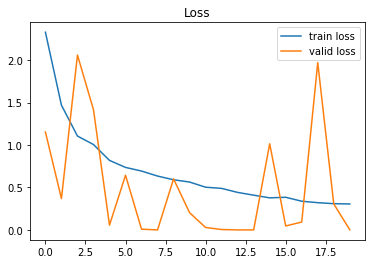

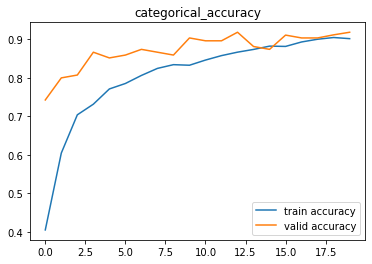

In [36]:
# Collect results
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]
train_acc = history.history["categorical_accuracy"]
valid_acc = history.history["val_categorical_accuracy"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("categorical_accuracy")
plt.show()

### Prediction

In [120]:
#載入訓練的模型
# predict_model_name = save_model_name
# predict_model_name = save_final_model_name
predict_model_name = 'model-resnet50-12-28T160610.h5'
model = keras.models.load_model(predict_model_name)

In [121]:
df = pd.read_csv('ml100-03-final/sample_submission.csv')
test_file_name_list = list(df.id)

In [122]:
x_test_sub = [];
for i, f_name in enumerate(test_file_name_list):
    im = cv2.imread(os.path.join('ml100-03-final/processed image data/test', f_name+'.jpg'))
    x_test_sub.append(im)
x_test_sub = np.array(x_test_sub)

x_test_sub_float = x_test_sub.astype('float32')
# x_test_sub_float /= 255

(2000, 240, 240, 3)
<class 'numpy.ndarray'>
(240, 240, 3)


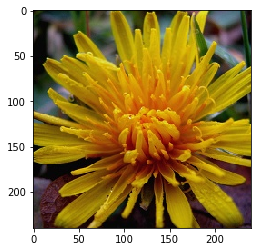

In [123]:
print(x_test_sub.shape)
test_img_01 = x_test_sub[6]
plt.imshow(cv2.cvtColor(test_img_01, cv2.COLOR_BGR2RGB))
print(type(test_img_01))
print(test_img_01.shape)

In [124]:
y_test_sub_predict = model.predict(x_test_sub)

In [125]:
print(y_test_sub_predict)

[[2.38738213e-11 3.20930837e-08 8.60265255e-01 2.60727643e-06
  1.39732212e-01]
 [1.91903418e-05 8.48013406e-06 8.90559022e-06 5.69157130e-08
  9.99963403e-01]
 [5.04811142e-05 5.16830653e-07 9.80550685e-05 4.29490638e-06
  9.99846578e-01]
 ...
 [1.00000000e+00 2.72686806e-17 1.10615505e-17 1.65083165e-20
  1.21812543e-19]
 [9.42246879e-06 9.68445435e-10 2.20235075e-09 2.16645257e-10
  9.99990582e-01]
 [4.22321864e-05 1.23515690e-03 9.97853458e-01 8.25445604e-05
  7.86499528e-04]]


In [126]:
print(type(y_test_sub_predict))
print(len(y_test_sub_predict))
print(y_test_sub_predict.shape)
print(y_test_sub_predict[0])
print(y_test_sub_predict[1])

<class 'numpy.ndarray'>
2000
(2000, 5)
[2.3873821e-11 3.2093084e-08 8.6026525e-01 2.6072764e-06 1.3973221e-01]
[1.9190342e-05 8.4801341e-06 8.9055902e-06 5.6915713e-08 9.9996340e-01]


In [127]:
predict_label = np.zeros((len(y_test_sub_predict), ), dtype=int)
for i, item in enumerate(y_test_sub_predict):
    predict_label[i] = np.argmax(item)

In [128]:
print(type(predict_label))
print(len(predict_label))
print(predict_label)

<class 'numpy.ndarray'>
2000
[2 4 4 ... 0 4 2]


[1436, 374, 1287, 1799, 1833]


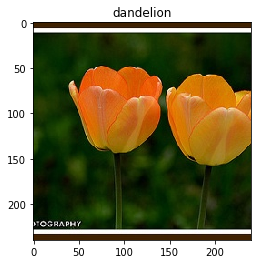

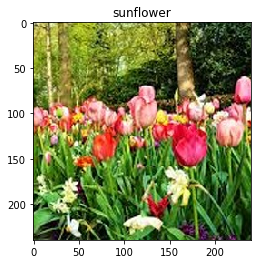

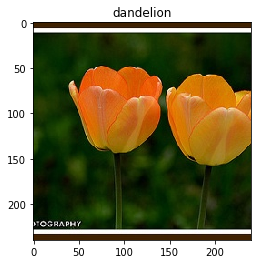

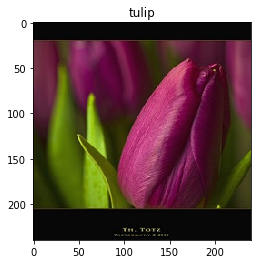

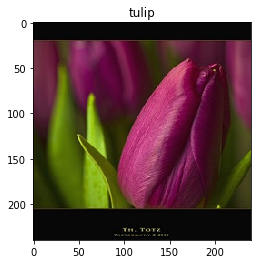

In [129]:
import random
show_num = 5  #秀 20 組預測組看看效果

ind_2000 = list(range(len(predict_label)))
random.shuffle(ind_2000)
ind_num = ind_2000[:show_num]
print(ind_num)
for idx in ind_num:
    plt.title(labels[predict_label[idx]])
    plt.imshow(cv2.cvtColor(x_test_sub[predict_label[idx]], cv2.COLOR_BGR2RGB))
    plt.show()

In [130]:
submission_df = pd.DataFrame()
submission_df['id'] = df['id']
submission_df['flower_class'] = predict_label
print(submission_df)

                                    id  flower_class
0     0028624c49b3e0610ff9f1d111f5d532             2
1     002c30700185b7971369258b438070d5             4
2     00852f4f666acecd0c0d140365b42efd             4
3     00c08828fce04e360c732cac01edad9e             4
4     00d366e7877b6a78b104b57d67b60e6b             4
...                                ...           ...
1995  ff7eac29b6d7a33fbd8009677c3e9c58             1
1996  ffbc32a7b67dfe72b8d35d4b1b35fd6c             1
1997  ffea1f275c05accb0a6bfd1203620c7e             0
1998  ffeb2a1cf53464b6af937ab8af0c2946             4
1999  ffefcc68e2e7eed8b17b0b5b0f740538             2

[2000 rows x 2 columns]


### 存檔成CSV

In [131]:
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)

submission_filename = 'Result_'+predict_model_name[:-3]+'.csv'
submission_df.to_csv(submission_filename, index=False)

* model_12-28T010428.h5              -> Public Score 0.46900
* model_12-28T105443.h5              -> Public Score 0.46800
* model-resnet50-12-28T145129.h5     -> Public Score 0.85200
* model-resnet50-12-28T160610.h5     -> Public Score 0.85200

In [132]:
print(predict_model_name)

model-resnet50-12-28T160610.h5
